# League of Legends Game Predictor

The data was gathered using [Riot's API](https://github.com/pseudonym117/Riot-Watcher/tree/master/docs/riotwatcher).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
dataset = pd.read_csv('data/league_data.csv')

In [3]:
# Let's make a dataset for the blue team to analyse their decisions

blue_side_columns = []
for col in dataset.columns:
       if "blue" in col:
              blue_side_columns.append(col)
                
blue_data = dataset[blue_side_columns]

In [4]:
blue_data.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0
1,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2
2,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3
3,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7
4,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0


In [5]:
# I need to clean this data for a logistic regression model, so I will make a copy and edit it
blue_data_cleaned = blue_data.copy()

In [6]:
# Removing assists and kills to see how hidden factors can influence the game
blue_data_cleaned['KA'] = blue_data_cleaned['blueAssists'] + blue_data_cleaned['blueKills']
blue_data_cleaned = blue_data_cleaned.drop(['blueAssists','blueKills'],axis=1)

In [7]:
# Removing all the metrics that pertain to gold
Gold = []
for column in list(blue_data_cleaned.columns):
    if 'Gold' in column:
        Gold.append(column)
        
blue_data_cleaned = blue_data_cleaned.drop(Gold,axis=1)

In [8]:
# Remove experience (xp) metrics
Experience = []
for column in list(blue_data_cleaned.columns):
    if 'Experience' in column:
        Experience.append(column)
        
blue_data_cleaned = blue_data_cleaned.drop(Experience,axis=1)

In [9]:
blue_data_cleaned = blue_data_cleaned.drop(['blueCSPerMin'],axis=1)
blue_data_cleaned = blue_data_cleaned.drop(['blueEliteMonsters'],axis=1)

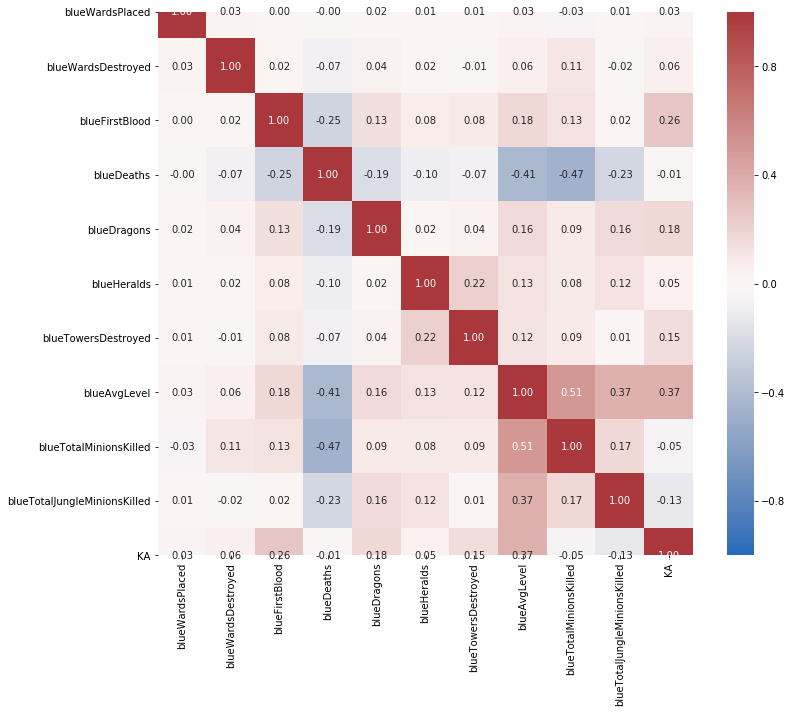

In [10]:
plt.figure(figsize=(12, 10))
sns.heatmap(blue_data_cleaned.drop("blueWins",axis=1).corr(),cmap='vlag', annot=True, fmt='.2f', vmin=-1)

In [11]:
# Some outliers here need to be investigated

blue_no_outliers = blue_data_cleaned.copy()

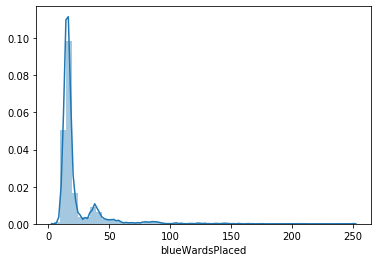

In [12]:
# Outlier 1 : Wards placed

sns.distplot(blue_no_outliers['blueWardsPlaced'])

In [13]:
# Realistically, nobody can place over 100 wards in a 10 minute game so we can trim this
#Remove everything above 99%

blue_no_outliers = blue_no_outliers.loc[blue_no_outliers['blueWardsPlaced'] <= np.quantile(blue_no_outliers['blueWardsPlaced'],q=0.99)]

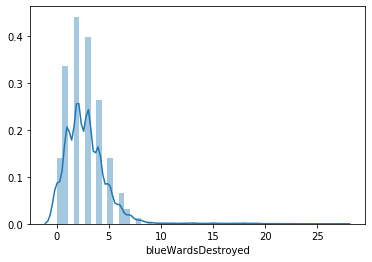

In [14]:
# Outlier 2 : Wards destroyed 
sns.distplot(blue_no_outliers['blueWardsDestroyed'])

In [15]:
# Same logic as wards placed, i.e. we can trim some outliers
blue_no_outliers = blue_no_outliers.loc[blue_no_outliers['blueWardsDestroyed'] <= np.quantile(blue_no_outliers['blueWardsDestroyed'],q=0.99)]

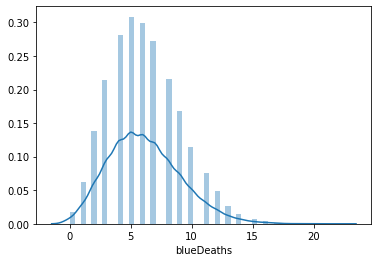

In [16]:
# Outlier 3 : Blue deaths

sns.distplot(blue_no_outliers['blueDeaths'])

In [17]:
# Trimming this as in losing games, the losing team will give kills so the game ends quicker. We only want to consider fair games

blue_no_outliers = blue_no_outliers.loc[blue_no_outliers['blueDeaths'] <= np.quantile(blue_no_outliers['blueDeaths'],q=0.99)]

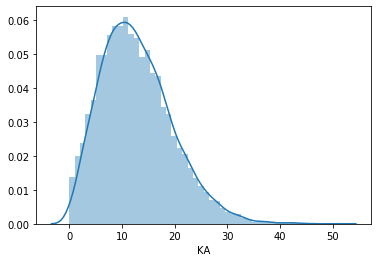

In [18]:
# Outlier 4 : Kills and assists

sns.distplot(blue_no_outliers['KA'])

In [19]:
# Remove everything over 99% for the same reason as above

blue_no_outliers = blue_no_outliers.loc[blue_no_outliers['KA'] <= np.quantile(blue_no_outliers['KA'],q=0.99)]

In [20]:
# Now that the outliers are removed, I need to see if their is a balance of wins/losses
blue_balanced = blue_no_outliers.copy()
print("In this current Dataset, there is {0:.3f}% of won games".format(
    blue_balanced['blueWins'].sum() / blue_balanced['blueWins'].shape[0]
    )
)

In this current Dataset, there is 0.499% of won games


In [21]:
blue_data_scaled = blue_balanced.copy()

In [22]:
blue_target = blue_balanced['blueWins']

In [23]:
blue_features = blue_balanced.drop(['blueWins'],axis=1)

In [24]:
# Standardise some features
scaler = StandardScaler()
scaler.fit(blue_features)

blue_features_scaled = scaler.transform(blue_features)

In [25]:
blue_features_scaled.mean(axis=0)

array([ 9.21624469e-17, -1.78378929e-17, -7.43245539e-18,  1.07770603e-16,
       -6.13177570e-17,  6.24326253e-17,  1.41216653e-17, -9.37975871e-16,
        4.15102634e-16,  3.38827060e-16, -3.97636364e-17])

In [26]:
blue_features_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [27]:
x_train, x_test, y_train, y_test = train_test_split(blue_features_scaled,blue_target, random_state=81, test_size=0.15)

In [28]:
# Regression model

regressor = LogisticRegression()
regressor.fit(blue_features_scaled,blue_target)

C:\Users\anura\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
regressor.score(blue_features_scaled,blue_target)

0.7120292887029289

71% accuracy... better than I thought. Now I want to see the weights and analyse what influences a win or loss.

In [30]:
blue_weights = pd.DataFrame()
blue_weights['Features'] = blue_features.columns
blue_weights['Weights'] = regressor.coef_.reshape(11,1)
blue_weights.sort_values(by='Weights',ascending=False)

,Features,Weights
10,KA,0.667218
7,blueAvgLevel,0.253461
4,blueDragons,0.227706
8,blueTotalMinionsKilled,0.152640
9,blueTotalJungleMinionsKilled,0.138038
6,blueTowersDestroyed,0.119600
2,blueFirstBlood,0.083456
5,blueHeralds,0.048750
1,blueWardsDestroyed,0.018473
0,blueWardsPlaced,-0.051445


# Analysis

* Kills and deaths matter a lot, which makes sense because it gives gold and xp.



* We can also think that valuing experience can lead to a win. For example, usualy, players have to make a choice between taking a risk leading to gaining or losing a lot of gold and experience (make a play and try to kill the enemy / roaming / invading), or they can play safe. It is therefore possible that playing safe and valuing experience by killing minions only could be a good decision to win the game later. Indeed, the game is actually more about punishing enemy mistakes than making high-value plays.


* Warding doesn't have a huge impact on winning/losing before 10 minutes, which makes sense because supports don't have their warding item yet and everyone (except the jungler) is visible on the map so no need to ward for roams.


* Also, getting the first drake in the game tends to increase the probability of winning, in opposite to the herald. This fact is pretty weird because in season 11/12, obtaining herald leads to destroying turrets, therefore golds for the entire team and map pressure, which is decisive for the win. This results should be investigated.